In [26]:
from pckgs.helper import PnlCallback
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sb
from pckgs.models import get_model_price
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from pckgs.evaluator import Evaluator
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Dense, Reshape, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
#read
df = pd.read_csv('./datasets/bitcoin_position_day_20_thres1.csv', header=0, parse_dates=['Timestamp'], index_col='Timestamp')

#split
y = df.loc[:, ['down', 'same', 'up']]
x = df.drop(['down', 'same', 'up'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

y_index = y_test.index
x_index = y_train.index

In [20]:
#create labeled y_test to measure pnl, confusion matrix
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)

y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)

In [32]:
df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_day.csv', header=0, parse_dates=['Timestamp'])
df_candle.rename(columns={'Timestamp':'date'}, inplace=True)
df_candle.set_index('date', inplace=True)
df_candle.rename(columns={'Open': 'open', 'Low': 'low', 'High': 'high', 'Close': 'close'}, inplace=True)
# align dates
df_candle_y = df_candle.reindex(y_index)
df_candle_x = df_candle.reindex(x_index)
# print(df_candle)
# print(x_test)

In [22]:
print(y_train.value_counts())

down  same  up
0     1     0     459
      0     1     399
1     0     0     294
dtype: int64


In [23]:
model = get_model_price()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 20, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 1,203
Trainable params: 1,203
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
from pckgs.helper import PnlCallback

# class_weights = {0:1.2, 1:1, 2:1}


# pnl = PnlCallback(x_test, df_candle, patience=60, name='model_price')
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=0, patience=60)
mc = ModelCheckpoint('model_price.h5',verbose=0, save_best_only=True)    #MLP

history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=32
                    # ,class_weight=class_weights
                    ,epochs=300, verbose=0, callbacks=[es, mc])#, shuffle=False)

model = load_model('model_price.h5')

<AxesSubplot:>

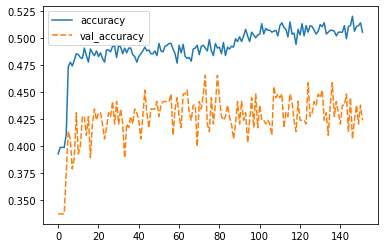

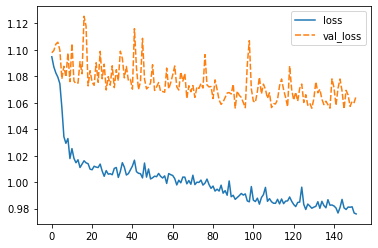

In [25]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)


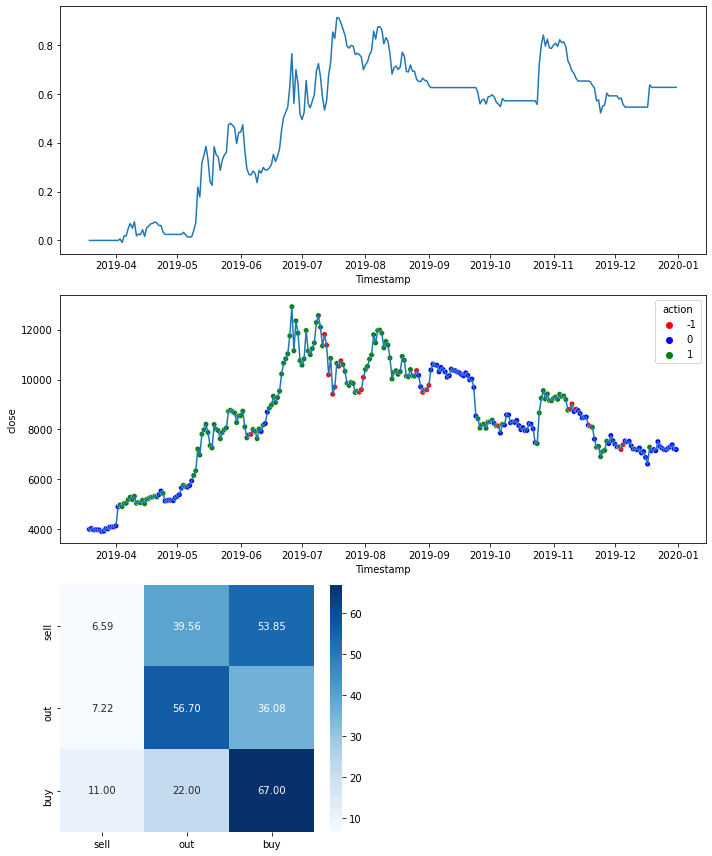

In [29]:
#create labeled y_pred for pnl, confusion matrix
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)


Evaluator.evaluate(y_pred_labeled, y_test_labeled, df_candle_y, force=False)

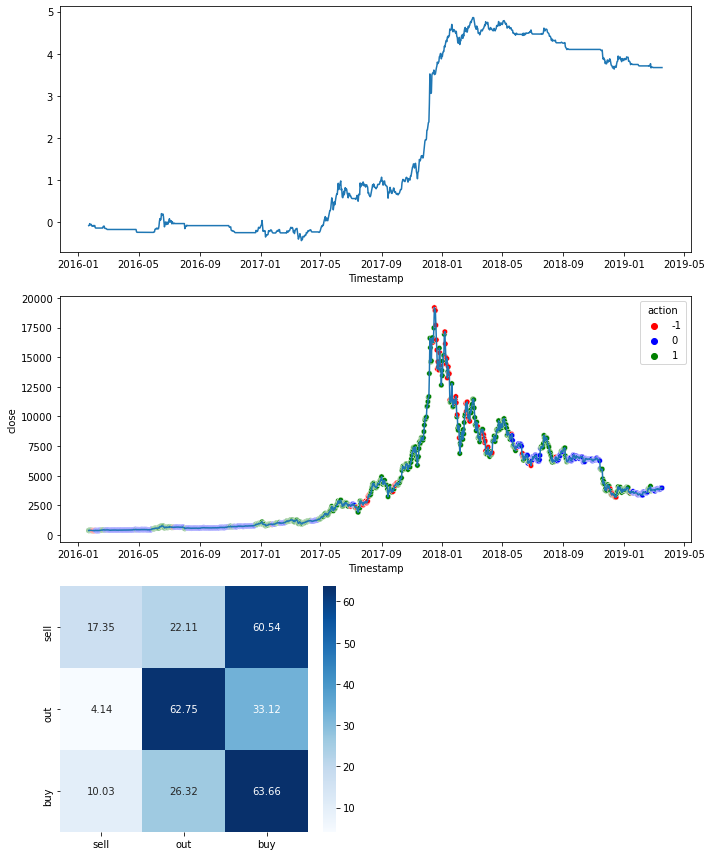

In [33]:
y_predt = model.predict(x_train)
y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=x_index)
y_predt_labeled = y_predt_labeled.idxmax(axis=1)

Evaluator.evaluate(y_predt_labeled, y_train_labeled, df_candle_x, force=False)

In [98]:
print(classification_report(y_test_labeled, y_pred_labeled))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        91
           0       0.42      0.75      0.54        97
           1       0.42      0.49      0.45       100

    accuracy                           0.42       288
   macro avg       0.28      0.41      0.33       288
weighted avg       0.29      0.42      0.34       288



/home/solon/anaconda3/envs/Ptyxiaki/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

